0 - Setup: Imports, Seeds, Paths

In [11]:
# 0) Setup: imports, random seeds, and file paths
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, auc, precision_recall_curve)

from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

np.random.seed(42)
tf.random.set_seed(42)

# Point this to the folder that contains the .npy files
DATA_DIR = "."  # change if needed


1- loading the images from .npy

In [48]:
# 1) Loading the images and labels from .npy files
print("Loading data from .npy files...")
X_train = np.load(os.path.join(DATA_DIR, "train_images.npy"))
y_train = np.load(os.path.join(DATA_DIR, "train_labels.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "test_images.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "test_labels.npy"))

print("Shapes:")
print("  X_train:", X_train.shape, "dtype:", X_train.dtype)
print("  y_train:", y_train.shape, "dtype:", y_train.dtype)
print("  X_test :", X_test.shape,  "dtype:", X_test.dtype)
print("  y_test :", y_test.shape,  "dtype:", y_test.dtype)


Loading data from .npy files...
Shapes:
  X_train: (60000, 28, 28, 1) dtype: float32
  y_train: (60000,) dtype: uint8
  X_test : (10000, 28, 28, 1) dtype: uint8
  y_test : (10000,) dtype: uint8


In [ ]:
#print("RAW max/min:", X_train_raw.max(), X_train_raw.min())
# means no need for scaling

RAW max/min: 1.0 0.0


2- quick visualisation of a few images

Showing a 4x5 grid of sample images from the training set...


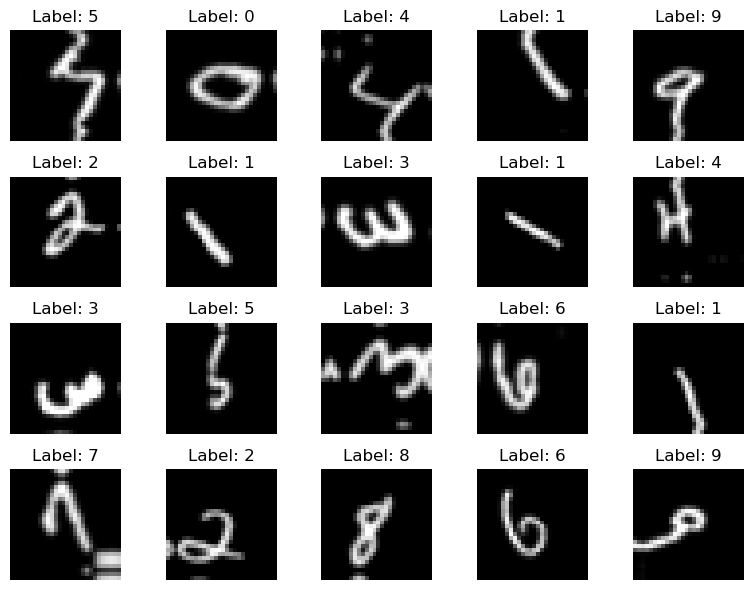

In [50]:
# 2) Visualize a few images with their labels
print("Showing a 4x5 grid of sample images from the training set...")
fig, axes = plt.subplots(4, 5, figsize=(8, 6))
axes = axes.ravel()
for i in range(20):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()



3 — Initial EDA: shapes, heads, stats, cleanliness, class distribution


Basic stats on pixel values (train):
  min: 0.0 max: 1.0 mean: 0.14200264 std: 0.23273616
Any NaNs in X_train? False
Any NaNs in X_test? False

Head of flattened pixel table (first 5 rows, first 10 features):
          0         1         2         3         4         5         6  \
0  0.057734  0.057734  0.057734  0.057734  0.057734  0.057734  0.057734   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.053084  0.000000  0.000000  0.012119  0.059128  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.083121  0.083121  0.083121  0.083121  0.083121  0.083121  0.083121   

          7         8         9  
0  0.057734  0.057734  0.057734  
1  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  
4  0.083121  0.083121  0.083121  

Class distribution (train):
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype:

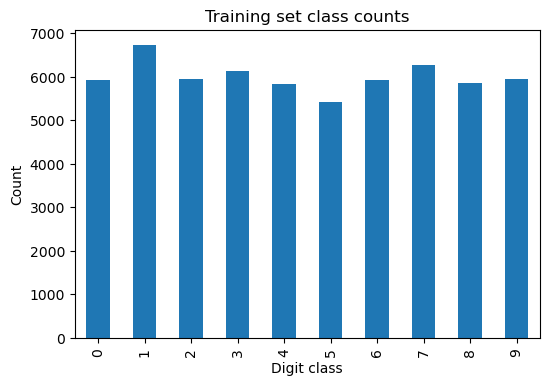

In [51]:
# 3) Initial EDA / sanity checks

print("\nBasic stats on pixel values (train):")
print("  min:", X_train.min(), "max:", X_train.max(), "mean:", X_train.mean(), "std:", X_train.std())
print("Any NaNs in X_train?", np.isnan(X_train).any())
print("Any NaNs in X_test?", np.isnan(X_test).any())

# Show a 'head' of the flattened pixels just to see structure
print("\nHead of flattened pixel table (first 5 rows, first 10 features):")
flat_head = X_train.reshape(len(X_train), -1)
print(pd.DataFrame(flat_head).iloc[:5, :10])

# Label distribution
unique, counts = np.unique(y_train, return_counts=True)
class_counts = pd.Series(counts, index=unique).sort_index()
print("\nClass distribution (train):")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar")
plt.title("Training set class counts")
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.show()


4 — Preprocessing: scaling, one-hot, train/val split, shapes for MLP & CNN

In [57]:
# 4) Preprocessing: scale pixels to [0,1], one-hot encode labels, and split train/val

# Scale pixels to [0,1] (keeps things numerically stable)
#X_train = X_train.astype("float32") / 255.0
#X_test  = X_test.astype("float32") / 255.0

num_classes = len(np.unique(y_train))
print("Detected number of classes:", num_classes)

# One-hot encoding for Keras training
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test,  num_classes=num_classes)

# Split a validation set out of training data
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train_oh, test_size=0.15, random_state=42, stratify=y_train
)
y_val_labels = np.argmax(y_val, axis=1)  # for some plots later

print("Train/Val/Test sizes:", X_train_full.shape[0], X_val.shape[0], X_test.shape[0])

# Prepare shapes for MLP (flatten) and CNN (H, W, 1)
X_train_mlp = X_train_full.reshape((len(X_train_full), -1))
X_val_mlp   = X_val.reshape((len(X_val), -1))
X_test_mlp  = X_test.reshape((len(X_test), -1))

# Optional standardization for the MLP (mean=0, std=1) — CNN will use raw [0,1] images
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_val_mlp   = scaler.transform(X_val_mlp)
X_test_mlp  = scaler.transform(X_test_mlp)

# # CNN shape
def to_float01(x):
    x = x.astype("float32")
    if x.max() > 1.5:   # only normalize if still in [0..255]
        x = x / 255.0
    return x

def ensure_channel_last(x):
    return x if x.ndim == 4 else x[..., np.newaxis]

X_train_cnn = ensure_channel_last(to_float01(X_train_full))
X_val_cnn   = ensure_channel_last(to_float01(X_val))
X_test_cnn  = ensure_channel_last(to_float01(X_test))



print("MLP input shape:", X_train_mlp.shape[1])
print("CNN input shape:", X_train_cnn.shape[1:])

# Optional sanity checks
# assert X_train_cnn.ndim == 4 and X_train_cnn.shape[-1] == 1
# print("CNN tensors:", X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)


Detected number of classes: 10
Train/Val/Test sizes: 51000 9000 10000
MLP input shape: 784
CNN input shape: (28, 28, 1)


5 — PCA & t-SNE (2D visualizations)

Running PCA on 8000 samples...


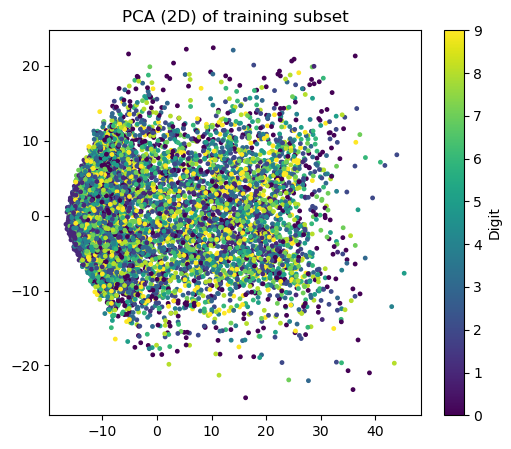

Running t-SNE (this can take a bit)...


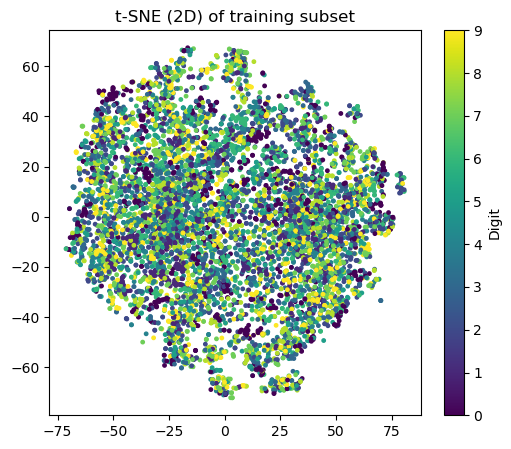

In [42]:
# 5) Dimensionality reduction plots (use a subset to keep it quick)
subset = 8000 if X_train_mlp.shape[0] > 8000 else X_train_mlp.shape[0]
X_sub = X_train_mlp[:subset]
y_sub = np.argmax(y_train_full[:subset], axis=1)

print(f"Running PCA on {subset} samples...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sub)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sub, s=6)
plt.title("PCA (2D) of training subset")
plt.colorbar(scatter, label="Digit")
plt.show()

print("Running t-SNE (this can take a bit)...")
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_sub)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sub, s=6)
plt.title("t-SNE (2D) of training subset")
plt.colorbar(scatter, label="Digit")
plt.show()


6 — Class weighting (only if needed)

In [58]:
# 6) Compute class weights if classes are imbalanced (harmless even if fairly balanced)
labels_train_full = np.argmax(y_train_full, axis=1)
classes = np.unique(labels_train_full)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels_train_full)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)


Class weights: {0: 1.012909632571996, 1: 0.889897051125458, 2: 1.0071090047393365, 3: 0.9786989061600461, 4: 1.026983487716472, 5: 1.1067708333333333, 6: 1.0139165009940359, 7: 0.9577464788732394, 8: 1.0255379046853006, 9: 1.008503065058335}


7 — Callbacks (EarlyStopping + ReduceLROnPlateau + ModelCheckpoint + a custom “AND” early stop)

In [ ]:
# ctr+/ to uncomment
# # 7) Useful callbacks

# # Standard callbacks
# early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, mode='max',
#                                      restore_best_weights=True, verbose=1)
# reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
#                                          min_lr=1e-6, verbose=1)
# ckpt_path = "best_cnn.keras"
# checkpoint = callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True,
#                                        mode='max', verbose=1)

# # Custom AND-logic EarlyStopping (stop only if both val_loss and val_accuracy haven't improved)
# class DualMetricEarlyStopping(callbacks.Callback):
#     def __init__(self, patience=5, min_delta_acc=0.0, min_delta_loss=0.0):
#         super().__init__()
#         self.patience = patience
#         self.min_delta_acc = min_delta_acc
#         self.min_delta_loss = min_delta_loss
#         self.best_acc = -np.inf
#         self.best_loss = np.inf
#         self.wait = 0

#     def on_epoch_end(self, epoch, logs=None):
#         acc = logs.get('val_accuracy')
#         loss = logs.get('val_loss')
#         improved_acc = (acc is not None) and (acc > self.best_acc + self.min_delta_acc)
#         improved_loss = (loss is not None) and (loss < self.best_loss - self.min_delta_loss)

#         if improved_acc:
#             self.best_acc = acc
#         if improved_loss:
#             self.best_loss = loss

#         # Stop only if NEITHER metric improved this epoch, for patience epochs in a row
#         if (not improved_acc) and (not improved_loss):
#             self.wait += 1
#         else:
#             self.wait = 0

#         if self.wait >= self.patience:
#             print(f"\nDualMetricEarlyStopping: no improvement in both metrics for {self.patience} epochs. Stopping.")
#             self.model.stop_training = True

# dual_and_stop = DualMetricEarlyStopping(patience=5, min_delta_acc=1e-4, min_delta_loss=1e-4)


In [59]:
from tensorflow.keras import callbacks

# ONLY classic EarlyStopping on validation accuracy
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


8 — First model (as in PDF): MLP (Dense) with ReLU/Softmax, cross-entropy, dropout=30%, RMSprop

In [46]:
# 8) Baseline MLP per PDF spec
def build_mlp(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.30),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.30),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mlp = build_mlp(X_train_mlp.shape[1], num_classes)
mlp.summary()

print("Training MLP...")
# hist_mlp = mlp.fit(
#     X_train_mlp, y_train_full,
#     validation_data=(X_val_mlp, y_val),
#     epochs=50, batch_size=256,
#     callbacks=[early_stop, reduce_lr],
#     class_weight=class_weights,  # optional if imbalance
#     verbose=2
# )
hist_mlp = mlp.fit(
    X_train_mlp, y_train_full,
    validation_data=(X_val_mlp, y_val),
    epochs=50, batch_size=256,
    #callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)
print("Evaluating MLP on test set...")
test_loss_mlp, test_acc_mlp = mlp.evaluate(X_test_mlp, y_test_oh, verbose=0)
print(f"MLP Test accuracy: {test_acc_mlp:.4f}")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Training MLP...
Epoch 1/50
200/200 - 1s - 7ms/step - accuracy: 0.3078 - loss: 1.9680 - val_accuracy: 0.4487 - val_loss: 1.6053
Epoch 2/50
200/200 - 1s - 4ms/step - accuracy: 0.4519 - loss: 1.5916 - val_accuracy: 0.5699 - val_loss: 1.3002
Epoch 3/50
200/200 - 1s - 4ms/step - accuracy: 0.5205 - loss: 1.4203 - val_accuracy: 0.6131 - val_loss: 1.1820
Epoch 4/50
200/200 - 1s - 4ms/step - accuracy: 0.5559 - loss: 1.3142 - val_accuracy: 0.6648 - val_loss: 1.0530
Epoch 5/50
200/200 - 1s - 4ms/step - accuracy: 0.5861 - loss: 1.2369 - val_accuracy: 0.6703 - val_loss: 1.0197
Epoch 6/50
200/200 - 1s - 4ms/step - accuracy: 0.6095 - loss: 1.1708 - val_accuracy: 0.6989 - val_loss: 0.9381
Epoch 7/50
200/200 - 1s - 4ms/step - accuracy: 0.6255 - loss: 1.1219 - val_accuracy: 0.7254 - val_loss: 0.8928
Epoch 8/50
200/200 - 1s - 4ms/step - accuracy: 0.6390 - loss: 1.0852 - val_accuracy: 0.7363 - val_loss: 0.8432
Epoch 9/50
200/200 - 1s - 4ms/step - accuracy: 0.6502 - loss: 1.0478 - val_accuracy: 0.7467 - va

9 — Second model (as in PDF): CNN (Conv2D)

In [61]:
# 9) CNN baseline
def build_cnn(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.30)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn = build_cnn(X_train_cnn.shape[1:], num_classes)
cnn.summary()

print("Training CNN...")
# hist_cnn = cnn.fit(
#     X_train_cnn, y_train_full,
#     validation_data=(X_val_cnn, y_val),
#     epochs=40, batch_size=256,
#     callbacks=[dual_and_stop, reduce_lr, checkpoint],
#     class_weight=class_weights,
#     verbose=2
# )
hist_cnn = cnn.fit(
    X_train_cnn, y_train_full,
    validation_data=(X_val_cnn, y_val),
    epochs=40, batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)


test_loss_cnn, test_acc_cnn = cnn.evaluate(X_test_cnn, y_test_oh, verbose=0)
print(f"CNN Test accuracy: {test_acc_cnn:.4f}")


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN...
Epoch 1/40
200/200 - 14s - 71ms/step - accuracy: 0.4177 - loss: 1.6731 - val_accuracy: 0.6819 - val_loss: 0.9599
Epoch 2/40
200/200 - 15s - 74ms/step - accuracy: 0.7611 - loss: 0.7551 - val_accuracy: 0.8818 - val_loss: 0.3951
Epoch 3/40
200/200 - 16s - 79ms/step - accuracy: 0.8561 - loss: 0.4649 - val_accuracy: 0.9189 - val_loss: 0.2690
Epoch 4/40
200/200 - 15s - 76ms/step - accuracy: 0.8949 - loss: 0.3409 - val_accuracy: 0.9297 - val_loss: 0.2415
Epoch 5/40
200/200 - 15s - 77ms/step - accuracy: 0.9127 - loss: 0.2821 - val_accuracy: 0.9490 - val_loss: 0.1717
Epoch 6/40
200/200 - 16s - 80ms/step - accuracy: 0.9247 - loss: 0.2428 - val_accuracy: 0.9543 - val_loss: 0.1524
Epoch 7/40
200/200 - 17s - 83ms/step - accuracy: 0.9370 - loss: 0.2061 - val_accuracy: 0.9559 - val_loss: 0.1462
Epoch 8/40
200/200 - 17s - 84ms/step - accuracy: 0.9425 - loss: 0.1885 - val_accuracy: 0.9561 - val_loss: 0.1506
Epoch 9/40
200/200 - 17s - 83ms/step - accuracy: 0.9458 - loss: 0.1741 - val_acc

10 — Training curves (diagnostics: loss/accuracy vs. epochs)

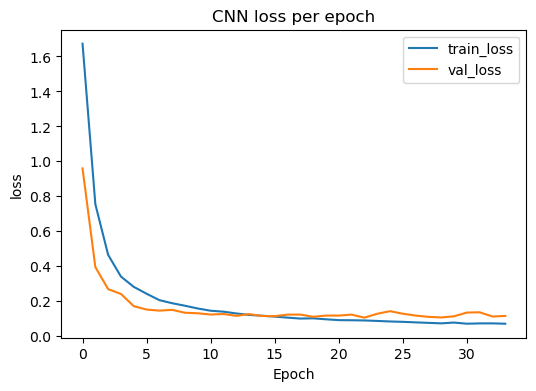

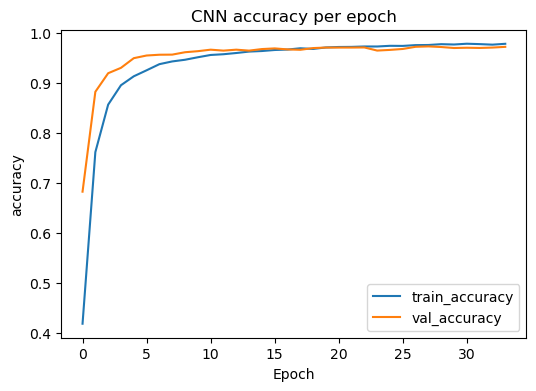

In [62]:
# 10) Plot training curves for the CNN (change to hist_mlp to inspect MLP)
def plot_history(history, title_prefix="Model"):
    metrics = [("loss", "val_loss"), ("accuracy", "val_accuracy")]
    for m, vm in metrics:
        plt.figure(figsize=(6,4))
        plt.plot(history.history[m], label=f"train_{m}")
        plt.plot(history.history[vm], label=f"val_{m}")
        plt.title(f"{title_prefix} {m} per epoch")
        plt.xlabel("Epoch")
        plt.ylabel(m)
        plt.legend()
        plt.show()

plot_history(hist_cnn, title_prefix="CNN")


11 — Evaluation helpers (confusion matrices, ROC & PR curves, AUCs)


MLP — Classification report:
              precision    recall  f1-score   support

           0     0.8704    0.9459    0.9066       980
           1     0.9733    0.8352    0.8990      1135
           2     0.6901    0.8459    0.7601      1032
           3     0.7586    0.8525    0.8028      1010
           4     0.8021    0.6232    0.7014       982
           5     0.7953    0.7186    0.7550       892
           6     0.8631    0.8225    0.8423       958
           7     0.7803    0.7947    0.7875      1028
           8     0.7341    0.7710    0.7521       974
           9     0.7443    0.7443    0.7443      1009

    accuracy                         0.7969     10000
   macro avg     0.8012    0.7954    0.7951     10000
weighted avg     0.8028    0.7969    0.7966     10000



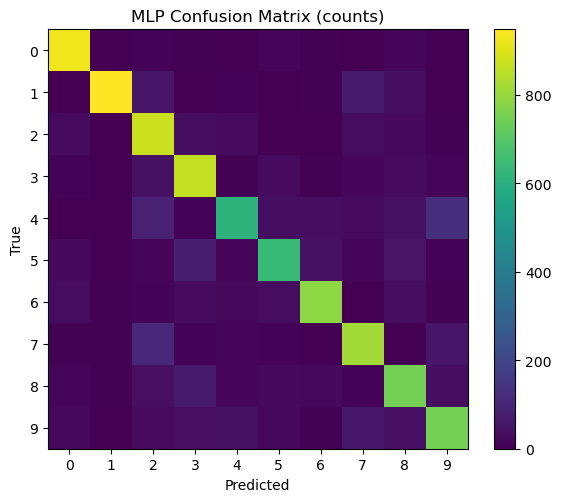

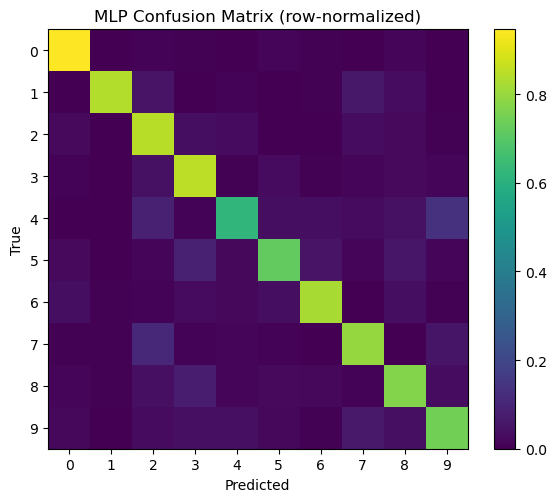

MLP ROC AUC — macro: 0.9125, micro: 0.9132


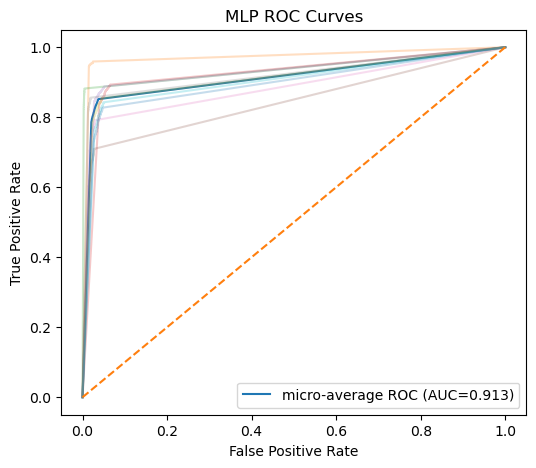

MLP PRC AUC — avg per-class: 0.8232 ± 0.0581


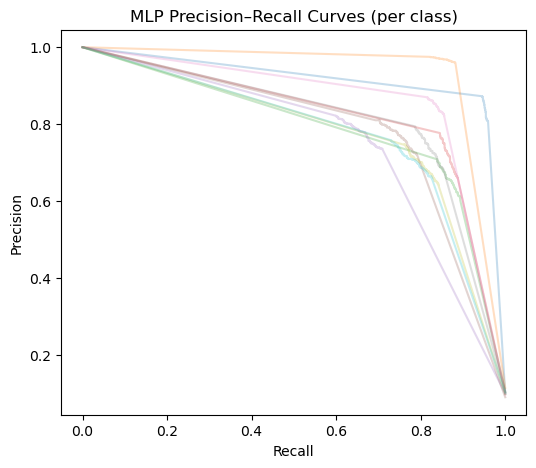


CNN — Classification report:
              precision    recall  f1-score   support

           0     0.9848    0.9929    0.9888       980
           1     0.9885    0.9877    0.9881      1135
           2     0.9693    0.9787    0.9740      1032
           3     0.9871    0.9822    0.9846      1010
           4     0.9676    0.9735    0.9706       982
           5     0.9719    0.9709    0.9714       892
           6     0.9751    0.9812    0.9781       958
           7     0.9641    0.9660    0.9650      1028
           8     0.9823    0.9671    0.9747       974
           9     0.9700    0.9604    0.9651      1009

    accuracy                         0.9762     10000
   macro avg     0.9761    0.9760    0.9760     10000
weighted avg     0.9762    0.9762    0.9762     10000



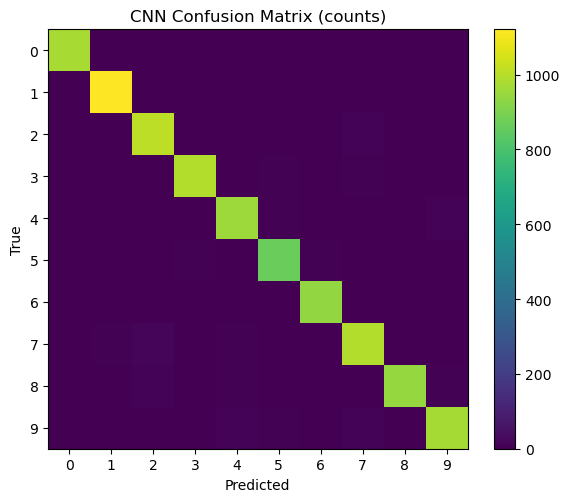

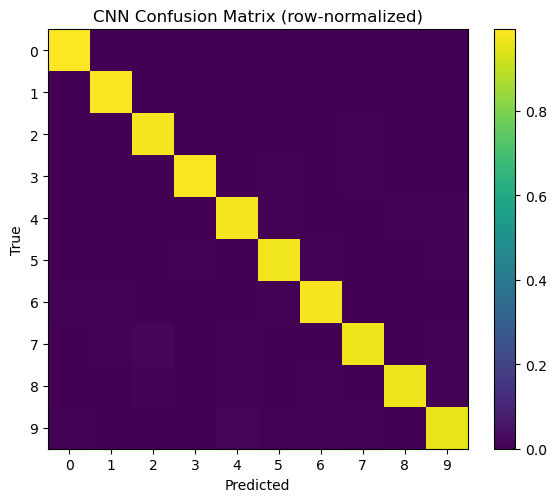

CNN ROC AUC — macro: 0.9994, micro: 0.9994


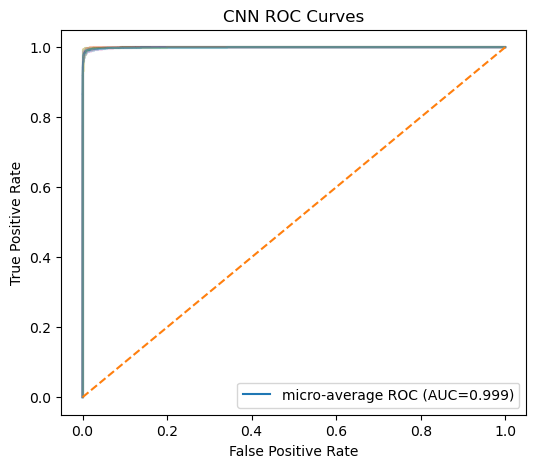

CNN PRC AUC — avg per-class: 0.9958 ± 0.0020


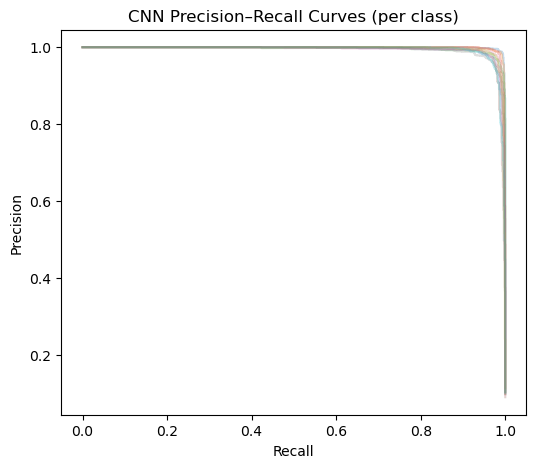

In [63]:
# 11) Metrics & plots: confusion matrices + ROC + PR curves

def evaluate_model(model, X_test_in, y_test_oh, y_test_labels, model_name="Model"):
    # Predictions
    y_prob = model.predict(X_test_in, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # Confusion matrices (raw and normalized)
    cm = confusion_matrix(y_test_labels, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    print(f"\n{model_name} — Classification report:")
    print(classification_report(y_test_labels, y_pred, digits=4))

    # Plot confusion matrices
    def plot_cm(C, title):
        plt.figure(figsize=(6,5))
        plt.imshow(C, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        ticks = np.arange(num_classes)
        plt.xticks(ticks, ticks)
        plt.yticks(ticks, ticks)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(cm, f"{model_name} Confusion Matrix (counts)")
    plot_cm(cm_norm, f"{model_name} Confusion Matrix (row-normalized)")

    # ROC & PRC (one-vs-rest)
    # Note: For multi-class ROC/PRC, we compute macro and micro averages
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_test_labels)  # shape: (N, C)
    if y_true_bin.shape[1] == 1:  # handle binary corner case
        y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

    # ROC AUC
    try:
        macro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
        micro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='micro', multi_class='ovr')
        print(f"{model_name} ROC AUC — macro: {macro_roc_auc:.4f}, micro: {micro_roc_auc:.4f}")
    except Exception as e:
        print("ROC AUC failed (probably due to degenerate predictions):", e)

    # Plot ROC curves (macro average)
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6,5))
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC={roc_auc['micro']:.3f})")
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.25)
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{model_name} ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision–Recall Curves (macro-ish view)
    precisions = []; recalls = []; pr_aucs = []
    for i in range(num_classes):
        pr, rc, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        precisions.append(pr); recalls.append(rc)
        pr_aucs.append(auc(rc, pr))
    print(f"{model_name} PRC AUC — avg per-class: {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}")

    plt.figure(figsize=(6,5))
    for i in range(num_classes):
        pr, rc = precisions[i], recalls[i]
        plt.plot(rc, pr, alpha=0.25)
    plt.title(f"{model_name} Precision–Recall Curves (per class)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Evaluate both MLP and CNN
evaluate_model(mlp, X_test_mlp, y_test_oh, y_test, model_name="MLP")
evaluate_model(cnn, X_test_cnn, y_test_oh, y_test, model_name="CNN")


12 — 5-Fold Stratified Cross-Validation (on the MLP for speed) — fold accuracies, mean, std

In [68]:
# 12) Stratified K-Fold CV (MLP amélioré)
print("Running 5-fold Stratified CV with the improved MLP...")
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

def build_mlp_v2(input_dim, num_classes):
    reg = regularizers.l2(1e-4)
    act = tf.keras.activations.gelu  # ou 'relu'
    model = models.Sequential(name="mlp_v2")
    model.add(layers.Input(shape=(input_dim,)))
    # Optionnel: légère injection de bruit pour régulariser l'entrée
    # model.add(layers.GaussianNoise(0.05))

    model.add(layers.Dense(512, activation=None, kernel_regularizer=reg))
    model.add(layers.BatchNormalization()); model.add(layers.Activation(act))
    model.add(layers.Dropout(0.20))

    model.add(layers.Dense(256, activation=None, kernel_regularizer=reg))
    model.add(layers.BatchNormalization()); model.add(layers.Activation(act))
    model.add(layers.Dropout(0.20))

    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

X_full_mlp = X_train.reshape((len(X_train), -1))
y_full_oh  = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_full_mlp, y_train), 1):
    tf.keras.backend.clear_session()

    scaler_cv = StandardScaler(with_mean=True, with_std=True)
    X_tr = scaler_cv.fit_transform(X_full_mlp[tr_idx])
    X_va = scaler_cv.transform(X_full_mlp[va_idx])

    model_cv = build_mlp_v2(X_tr.shape[1], num_classes)

    es  = callbacks.EarlyStopping(monitor='val_accuracy', patience=4,
                                  restore_best_weights=True, verbose=0)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=2, min_lr=1e-5, verbose=0)

    print(f"\nFold {fold}...")
    model_cv.fit(
        X_tr, y_full_oh[tr_idx],
        validation_data=(X_va, y_full_oh[va_idx]),
        epochs=30, batch_size=256,
        callbacks=[es, rlr],
        verbose=0
    )
    _, val_acc = model_cv.evaluate(X_va, y_full_oh[va_idx], verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Fold {fold} val accuracy: {val_acc:.4f}")

print("\nCV accuracies:", [f"{a:.4f}" for a in fold_accuracies])
print(f"Mean acc: {np.mean(fold_accuracies):.4f}  |  Std: {np.std(fold_accuracies):.4f}")


Running 5-fold Stratified CV with the improved MLP...

Fold 1...
Fold 1 val accuracy: 0.8802

Fold 2...
Fold 2 val accuracy: 0.8852

Fold 3...
Fold 3 val accuracy: 0.8865

Fold 4...
Fold 4 val accuracy: 0.8876

Fold 5...
Fold 5 val accuracy: 0.8856

CV accuracies: ['0.8802', '0.8852', '0.8865', '0.8876', '0.8856']
Mean acc: 0.8850  |  Std: 0.0025


In [73]:
# Train the improved Dense model (MLP v2) once on the full train/val split
print("\nTraining improved Dense model (MLP v2) on full train/val...")

mlp_v2 = build_mlp_v2(X_train_mlp.shape[1], num_classes)

es_full  = callbacks.EarlyStopping(monitor='val_accuracy', patience=4,
                                   restore_best_weights=True, verbose=1)
rlr_full = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                       patience=2, min_lr=1e-5, verbose=1)

hist_mlp_v2 = mlp_v2.fit(
    X_train_mlp, y_train_full,
    validation_data=(X_val_mlp, y_val),
    epochs=30, batch_size=256,
    callbacks=[es_full, rlr_full],
    class_weight=class_weights,
    verbose=2
)

print("Evaluating improved Dense model (MLP v2) on test set...")
test_loss_mlp_v2, test_acc_mlp_v2 = mlp_v2.evaluate(X_test_mlp, y_test_oh, verbose=0)
print(f"Improved MLP (Dense v2) Test accuracy: {test_acc_mlp_v2:.4f}")



Training improved Dense model (MLP v2) on full train/val...
Epoch 1/30
200/200 - 3s - 16ms/step - accuracy: 0.4423 - loss: 1.7449 - val_accuracy: 0.5592 - val_loss: 1.3715 - learning_rate: 1.0000e-03
Epoch 2/30
200/200 - 2s - 11ms/step - accuracy: 0.6341 - loss: 1.2199 - val_accuracy: 0.6858 - val_loss: 1.0657 - learning_rate: 1.0000e-03
Epoch 3/30
200/200 - 2s - 11ms/step - accuracy: 0.7062 - loss: 1.0178 - val_accuracy: 0.7430 - val_loss: 0.9028 - learning_rate: 1.0000e-03
Epoch 4/30
200/200 - 2s - 11ms/step - accuracy: 0.7438 - loss: 0.9037 - val_accuracy: 0.7772 - val_loss: 0.8097 - learning_rate: 1.0000e-03
Epoch 5/30
200/200 - 2s - 11ms/step - accuracy: 0.7728 - loss: 0.8178 - val_accuracy: 0.7988 - val_loss: 0.7520 - learning_rate: 1.0000e-03
Epoch 6/30
200/200 - 3s - 13ms/step - accuracy: 0.7916 - loss: 0.7580 - val_accuracy: 0.8031 - val_loss: 0.7250 - learning_rate: 1.0000e-03
Epoch 7/30
200/200 - 2s - 12ms/step - accuracy: 0.8127 - loss: 0.7026 - val_accuracy: 0.8216 - val_

13 — A small ResNet for 28×28×1

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │        288 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │      9,216 │ re_lu_9[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │      9,216 │ re_lu_10[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 28, 28,    │          0 │ add_4[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 28, 28,    │      9,216 │ re_lu_11[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │      9,216 │ re_lu_12[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 170,794 (667.16 KB)

 Trainable params: 169,834 (663.41 KB)

 Non-trainable params: 960 (3.75 KB)

Training small ResNet...
Epoch 1/40
200/200 - 63s - 316ms/step - accuracy: 0.6781 - loss: 1.0496 - val_accuracy: 0.1123 - val_loss: 3.3281
Epoch 2/40
200/200 - 64s - 318ms/step - accuracy: 0.9283 - loss: 0.2798 - val_accuracy: 0.7940 - val_loss: 0.8728
Epoch 3/40
200/200 - 66s - 328ms/step - accuracy: 0.9519 - loss: 0.1822 - val_accuracy: 0.9377 - val_loss: 0.2390
Epoch 4/40
200/200 - 66s - 332ms/step - accuracy: 0.9599 - loss: 0.1479 - val_accuracy: 0.9624 - val_loss: 0.1409
Epoch 5/40
200/200 - 71s - 354ms/step - accuracy: 0.9656 - loss: 0.1259 - val_accuracy: 0.9628 - val_loss: 0.1332
Epoch 6/40
200/200 - 67s - 336ms/step - accuracy: 0.9686 - loss: 0.1109 - val_accuracy: 0.9666 - val_loss: 0.1170
Epoch 7/40
200/200 - 65s - 324ms/step - accuracy: 0.9726 - loss: 0.0964 - val_accuracy: 0.9603 - val_loss: 0.1381
Epoch 8/40
200/200 - 66s - 332ms/step - accuracy: 0.9750 - loss: 0.0881 - val_accuracy: 0.9534 - val_loss: 0.1514
Epoch 9/40
200/200 - 66s - 330ms/step - accuracy: 0.9771 - loss

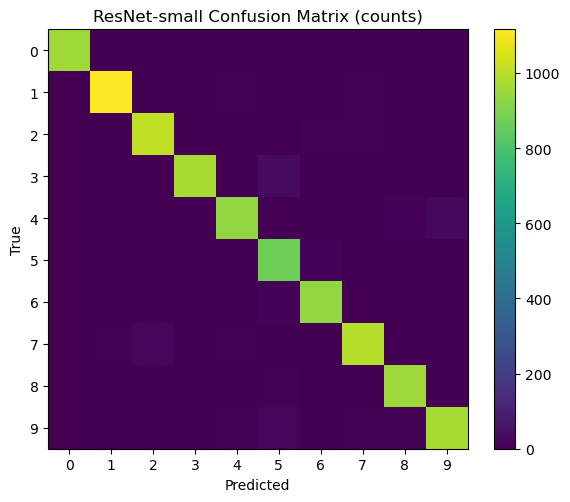

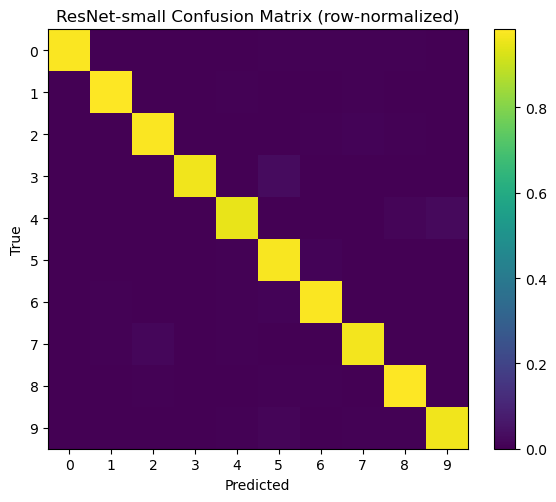

ResNet-small ROC AUC — macro: 0.9992, micro: 0.9992


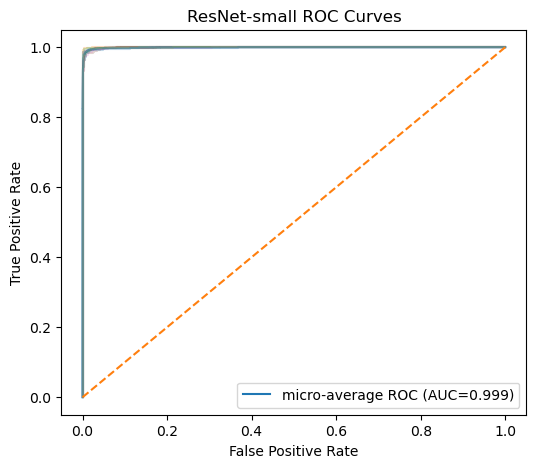

ResNet-small PRC AUC — avg per-class: 0.9948 ± 0.0029


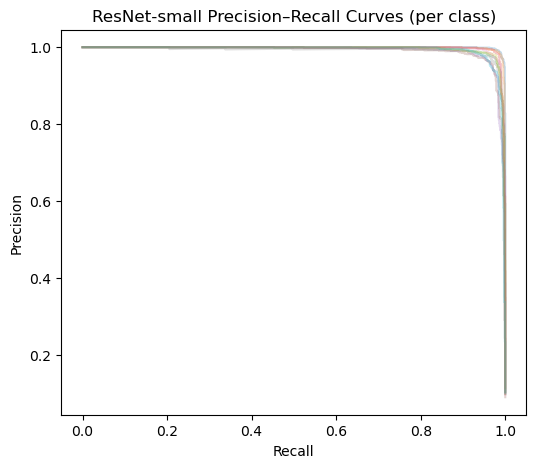

In [72]:
# 13) Small ResNet for grayscale 28x28
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match channels/stride for the shortcut if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_small(input_shape=(28,28,1), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model
resnet = build_resnet_small(X_train_cnn.shape[1:], num_classes)
resnet.summary()

print("Training small ResNet...")
# Important: use a fresh EarlyStopping (don't reuse from CNN!)
es_res = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

hist_resnet = resnet.fit(
    X_train_cnn, y_train_full,
    validation_data=(X_val_cnn, y_val),
    epochs=40, batch_size=256,
    callbacks=[es_res],
    class_weight=class_weights,
    verbose=2
)

print("Evaluate ResNet on test set...")
test_loss_res, test_acc_res = resnet.evaluate(X_test_cnn, y_test_oh, verbose=0)
print(f"ResNet Test accuracy: {test_acc_res:.4f}")

# Optional: evaluate plots
evaluate_model(resnet, X_test_cnn, y_test_oh, y_test, model_name="ResNet-small")

Skipped for now: 14 — Transfer learning (MobileNetV2) by promoting grayscale → RGB and resizing
Note: ImageNet backbones expect RGB. We replicate the gray channel to 3 channels and resize to 96×96 (keeps compute modest).

In [ ]:
# 14) Transfer learning with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Prepare resized RGB arrays (do once)
def to_rgb_and_resize(x, target=96):
    # x: (N,H,W) ou (N,H,W,1)
    xt = tf.convert_to_tensor(x)
    if xt.shape.rank == 3:               # (N,H,W) -> (N,H,W,1)
        xt = xt[..., tf.newaxis]
    # maintenant (N,H,W,1)
    xt = tf.image.grayscale_to_rgb(xt)   # -> (N,H,W,3)
    xt = tf.image.resize(xt, (target, target))
    return xt.numpy()


print("Converting train/val/test to 96x96 RGB for transfer learning...")
X_train_rgb = to_rgb_and_resize(X_train_full)
X_val_rgb   = to_rgb_and_resize(X_val)
X_test_rgb  = to_rgb_and_resize(X_test)

# Preprocess for MobileNetV2
X_train_rgb = preprocess_input(X_train_rgb * 255.0)  # expects 0..255 then mobilenet preprocess
X_val_rgb   = preprocess_input(X_val_rgb   * 255.0)
X_test_rgb  = preprocess_input(X_test_rgb  * 255.0)

def build_mobilenet_head(input_shape=(96,96,3), num_classes=10, train_base=False):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = train_base
    inp = layers.Input(shape=input_shape)
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mobilenet = build_mobilenet_head((96,96,3), num_classes, train_base=False)
mobilenet.summary()

print("Training MobileNetV2 head (frozen base)...")
# hist_tl = mobilenet.fit(
#     X_train_rgb, y_train_full,
#     validation_data=(X_val_rgb, y_val),
#     epochs=20, batch_size=256,
#     callbacks=[early_stop, reduce_lr],
#     class_weight=class_weights,
#     verbose=2
# )
hist_tl = mobilenet.fit(
    X_train_rgb, y_train_full,
    validation_data=(X_val_rgb, y_val),
    epochs=20, batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)

print("Evaluating TL model (frozen) on test set...")
_, acc_tl = mobilenet.evaluate(X_test_rgb, y_test_oh, verbose=0)
print(f"MobileNetV2 (frozen base) Test accuracy: {acc_tl:.4f}")

# Optional fine-tuning
base = mobilenet.layers[1]  # la couche index 1 est normalement le sous-modèle 'MobileNetV2'
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

mobilenet.compile(optimizer=optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# hist_tl_ft = mobilenet.fit(
#     X_train_rgb, y_train_full,
#     validation_data=(X_val_rgb, y_val),
#     epochs=15, batch_size=256,
#     callbacks=[early_stop, reduce_lr],
#     class_weight=class_weights,
#     verbose=2
# )
hist_tl_ft = mobilenet.fit(
    X_train_rgb, y_train_full,
    validation_data=(X_val_rgb, y_val),
    epochs=15, batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)


print("Evaluating fine-tuned TL model on test set...")
_, acc_tl_ft = mobilenet.evaluate(X_test_rgb, y_test_oh, verbose=0)
print(f"MobileNetV2 (fine-tuned) Test accuracy: {acc_tl_ft:.4f}")

evaluate_model(mobilenet, X_test_rgb, y_test_oh, y_test, model_name="MobileNetV2 TL")


15 — Quick comparison summary (print all test accuracies together)

In [75]:
# 15) Compare the different approaches we tried
# 15) Summary: test accuracies + CV (si dispo)

summary_rows = []

# Ajoute MLP v1 si entraîné
if "test_acc_mlp" in globals():
    summary_rows.append(("MLP (Dense v1, test)", test_acc_mlp))

# Ajoute MLP v2 si entraîné
if "test_acc_mlp_v2" in globals():
    summary_rows.append(("MLP (Dense v2, test)", test_acc_mlp_v2))

# Ajoute CNN si entraîné
if "test_acc_cnn" in globals():
    summary_rows.append(("CNN (Conv2D, test)", test_acc_cnn))

# Ajoute ResNet si entraîné
if "test_acc_res" in globals():
    summary_rows.append(("ResNet-small (test)", test_acc_res))

print("\n=== Summary of accuracies ===")
for name, acc in summary_rows:
    print(f"{name:25s} : {acc:.4f}")

# Ajoute la CV si elle existe (métrique de validation, pas test)
if "fold_accuracies" in globals() and len(fold_accuracies) > 0:
    cv_mean_acc = float(np.mean(fold_accuracies))
    cv_std_acc  = float(np.std(fold_accuracies))
    print(f"{'MLP (5-fold CV, val)':25s} : {cv_mean_acc:.4f}")
    print(f"   (CV std: {cv_std_acc:.4f})")




=== Summary of accuracies ===
MLP (Dense v1, test)      : 0.7969
MLP (Dense v2, test)      : 0.7947
CNN (Conv2D, test)        : 0.9762
ResNet-small (test)       : 0.9712
MLP (5-fold CV, val)      : 0.8850
   (CV std: 0.0025)


good for now but for dense v2 i think the loss at the end was too high ? go back and check that out